<a href="https://colab.research.google.com/github/Aleena-Shafiq/Renalystic/blob/main/Desnser121_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Install necessary libraries
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.all import *

# Define paths and load the dataset
path = Path('/content/gdrive/My Drive/Dataset')
train_fnames = get_image_files(path/"Train")



Mounted at /content/gdrive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.8 MB/s e

In [ ]:
# Data block and DataLoader setup
augs = [RandomResizedCropGPU(size=224, min_scale=0.75), Rotate(), Zoom()]
dblock = DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                   splitter=RandomSplitter(valid_pct=0.2, seed=23),
                   get_y=parent_label,
                   item_tfms=Resize(512, method="squish"),
                   batch_tfms=augs,
                   )
dls = dblock.dataloaders(train_fnames)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


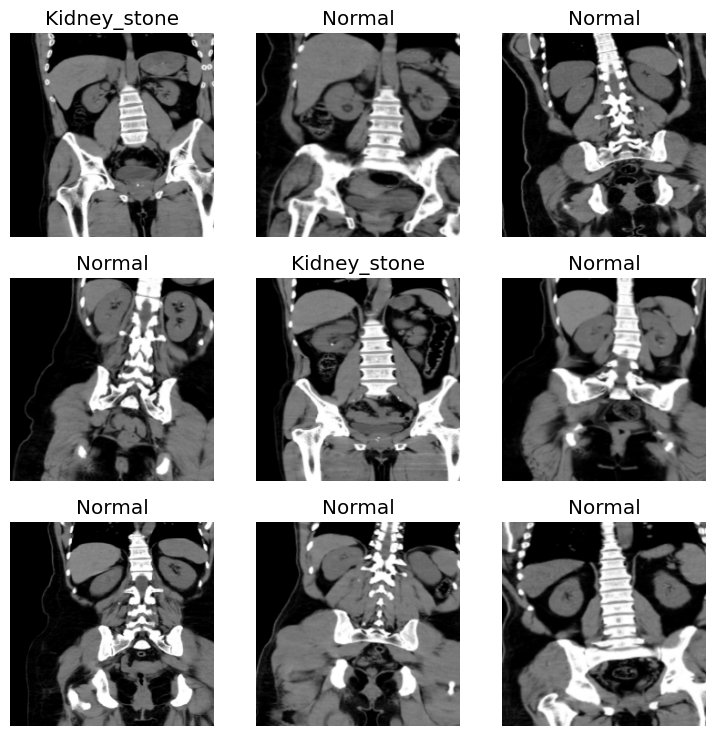

In [ ]:
dls.c, len(dls.train_ds), len(dls.valid_ds)
dls.vocab
dls.show_batch()

# Model setup with a different model (densenet121)
model = nn.Sequential(create_body(densenet121(pretrained=False), cut=-1),
                      create_head(nf=1024, n_out=2))  # Adjust the number of output classes if needed
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)





epoch,train_loss,valid_loss,accuracy,time
0,0.842935,0.729107,0.575342,03:22
1,0.767185,2.399102,0.589041,00:57
2,0.736124,2.551727,0.589041,01:00
3,0.704154,0.964358,0.609589,00:57
4,0.676239,1.090629,0.654110,00:59
5,0.621159,2.645739,0.654110,00:59
6,0.635742,3.101810,0.613014,00:57
7,0.602813,13.732547,0.410959,00:57
8,0.565246,3.537113,0.602740,00:59
9,0.535677,12.183657,0.630137,00:59


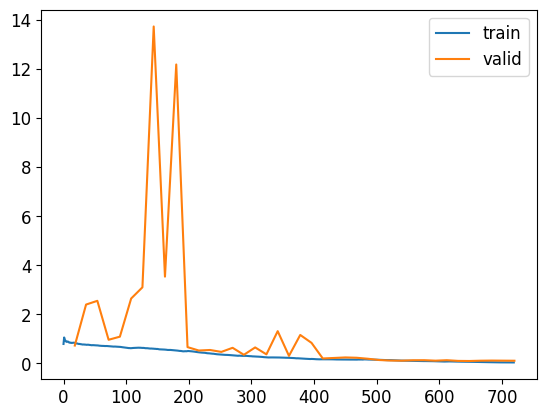

In [ ]:
# Train the model
# Train the model
learn.fit_one_cycle(40, 1e-2)
# Save the model with .pkl extension
learn.save(path/'kidney-densenet121')
learn.recorder.plot_loss(skip_start=0, with_valid=True)

In [ ]:
# Load the model from .pth file
model = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy).load(path/'kidney-densenet121.pkl')

# Save the loaded model in .pkl format
with open(path/'kidney-densenet121.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
import torch
import pickle
import gzip
model = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy).load(path/'kidney-densenet121.pkl')

# Save the loaded model in .pkl format
with gzip.open(path/'kidney-densenet121.pkl.gz', 'wb') as f:
    pickle.dump(model, f)

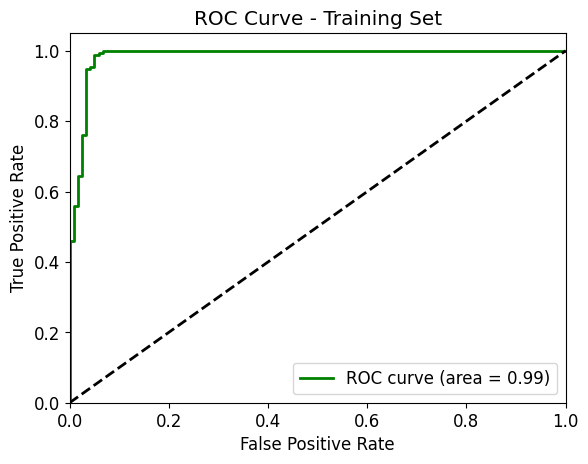

In [ ]:
from sklearn.metrics import roc_curve, auc



# Calculate probabilities for the training set
probs_train, targets_train = learn.get_preds()

# Calculate ROC curve and AUC for training set
fpr, tpr, thresholds = roc_curve(targets_train, probs_train[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Set')
plt.legend(loc="lower right")
plt.show()


              precision    recall  f1-score   support

Kidney_stone       0.99      0.94      0.97       120
      Normal       0.96      0.99      0.98       172

    accuracy                           0.97       292
   macro avg       0.98      0.97      0.97       292
weighted avg       0.97      0.97      0.97       292



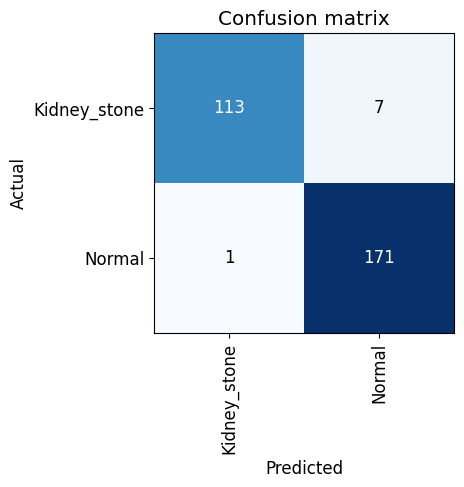

In [ ]:
# Training set confusion matrix and classification report
interp_train = ClassificationInterpretation.from_learner(learn)
interp_train.plot_confusion_matrix()
interp_train.print_classification_report()

In [ ]:
# Save the DataLoaders
torch.save(dls, path/'dls_densenet121.pkl')



In [ ]:
# Testing on a separate dataset
all_files = get_image_files(path)
augs = [RandomResizedCropGPU(size=224, min_scale=0.75), Rotate(), Zoom()]
dblock = DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                   splitter=GrandparentSplitter(train_name='Train', valid_name='Test'),
                   get_y=parent_label,
                   item_tfms=Resize(512, method="squish"),
                   batch_tfms=augs,
                   )
dls_test = dblock.dataloaders(all_files)




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


              precision    recall  f1-score   support

Kidney_stone       0.99      0.92      0.95       165
      Normal       0.93      0.99      0.96       181

    accuracy                           0.95       346
   macro avg       0.96      0.95      0.95       346
weighted avg       0.96      0.95      0.95       346



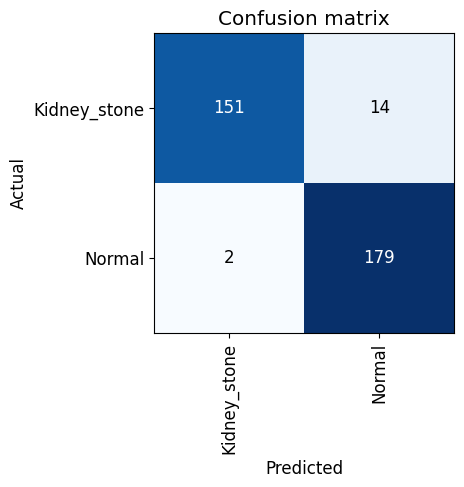

In [ ]:
# Create a new model with densenet121 architecture
model_test = nn.Sequential(create_body(densenet121(pretrained=False), cut=-1),
                           create_head(nf=1024, n_out=2))  # Adjust the number of output classes if needed
learn_test = Learner(dls_test, model_test, loss_func=CrossEntropyLossFlat(), metrics=accuracy).load('/content/gdrive/My Drive/Dataset/kidney-densenet121')

# Interpretation and analysis
interp = ClassificationInterpretation.from_learner(learn_test)
interp.plot_confusion_matrix()
interp.print_classification_report()

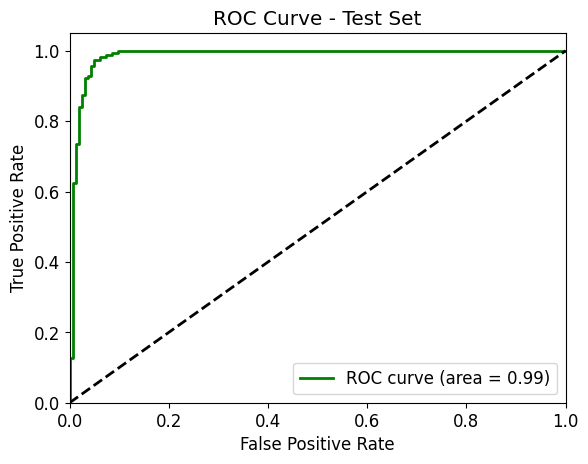

In [ ]:
from sklearn.metrics import roc_curve, auc

# Calculate probabilities for the test set
probs_test, targets_test = learn_test.get_preds()

# Calculate ROC curve and AUC for test set
fpr_test, tpr_test, thresholds_test = roc_curve(targets_test, probs_test[:, 1])
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve for test set
plt.figure()
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Install necessary libraries
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.all import *
from fastai.vision.models import xresnet

# Add this import for xresnet
from fastai.vision.models import xresnet

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Define paths and load the dataset
path = Path('/content/gdrive/My Drive/Dataset')
train_fnames = get_image_files(path/"Train")

# Data block and DataLoader setup (replace this with your data loading code)
augs = [RandomResizedCropGPU(size=224, min_scale=0.75), Rotate(), Zoom()]
dblock = DataBlock(blocks=(ImageBlock(cls=PILImage), CategoryBlock),
                   splitter=RandomSplitter(valid_pct=0.2, seed=23),
                   get_y=parent_label,
                   item_tfms=Resize(512, method="squish"),
                   batch_tfms=augs,
                   )
dls = dblock.dataloaders(train_fnames)


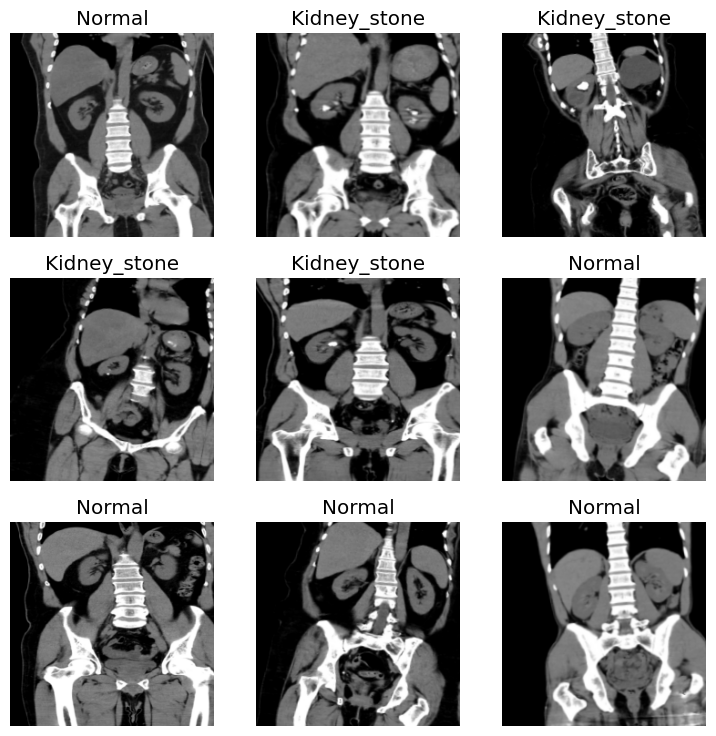

In [ ]:
dls.c, len(dls.train_ds), len(dls.valid_ds)
dls.vocab
dls.show_batch()

# Model setup
model = nn.Sequential(create_body(xresnet.xresnet50(pretrained=False), cut=-4),
                      create_head(nf=2048, n_out=2))
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
